In [120]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from datetime import datetime
from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [121]:
import os
root = os.getcwd()

In [122]:
root

'/home/ai001/Desktop/yau/my/merge'

In [123]:
lat, lng = (29.954163689899758, -90.10036833780715)
id_ = 'fQTgtv3VsocshUiPDBCOEQ'

In [124]:
yelp=pd.read_csv(root + "/../yelp/processed.csv")
photo = pd.read_json(root + '/../yelp/photos.json', lines=True)

userid = pd.read_csv(root + '/../rating/userid_map.csv').set_index('user_id')['userIntID'].to_dict()
restid = pd.read_csv(root + '/../rating/restid_map.csv').set_index('business_id')['restIntID'].to_dict()
sentiment = pd.read_csv(root + '/../text/sentiment_map.csv').set_index('userid')['Sentiment_Type'].to_dict()

In [125]:
import ast
nonstr = ast.literal_eval(yelp["attributes"].values[0])

import ast
def str2dict(strJson):
  nonstr = ast.literal_eval(strJson)
  
  for i in nonstr:
    nonstr[i]=ast.literal_eval(nonstr[i])

  return nonstr

  df=pd.json_normalize(nonstr)
  df.columns="attributes."+df.columns
  return df

def dict2df(colName):
  targetDict=np.array([])
  for i in yelp[colName].values:
    targetDict = np.append(targetDict, str2dict(i))

  targetDF=pd.json_normalize(targetDict)
  targetDF.columns = colName + "." + targetDF.columns
  return targetDF

attDF=dict2df("attributes")
attDF=attDF.fillna(False)

attDF=attDF[attDF.dtypes[attDF.dtypes=="bool"].keys()]

In [126]:
tmp = pd.concat([yelp.drop('attributes', axis = 1), attDF], axis = 1)
feature_DF = tmp.select_dtypes(include=bool)
(feature_DF.sum()>19000).loc[feature_DF.sum()>19000].index[:-1]
feature_DF=feature_DF[(feature_DF.sum()>19000).loc[feature_DF.sum()>19000].index[:-1]]
feature_DF=feature_DF.astype(int)

yelp = pd.concat([yelp.drop('attributes', axis = 1), feature_DF], axis = 1)

yelp = yelp[yelp.user_id == id_]

# Image Model

In [127]:
# Import necessary packages.
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image

# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder

# This is for the progress bar.
from tqdm.auto import tqdm

In [128]:
# It is important to do data augmentation in training.
image_size = 128

train_tfm = transforms.Compose([
    transforms.RandomResizedCrop((image_size, image_size)),
    transforms.RandomChoice(
        [transforms.AutoAugment(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN)]
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.5, 0.7)),
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.

test_tfm = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

In [129]:
# A greater batch size usually gives a more stable gradient.
batch_size = 128

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
# train_set = DatasetFolder("image/train/", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
# valid_set = DatasetFolder("image/validate", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
#unlabeled_set = DatasetFolder("image/train", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder(root + "/image", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
# valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [130]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 64, 64]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),

            nn.Conv2d(32, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),

        )
        self.fc_layers = nn.Sequential(
            nn.Linear(3136, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 4)
        )
        
    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [131]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
image_model = Classifier().to(device)
image_model.device = device


#Read trained model you saved
#model = Classifier().to(device)
#model.load_state_dict(torch.load("model.ckpt", map_location=lambda storage, loc: storage))
#model.device = device


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(image_model.parameters(), lr=4e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                        mode='max',
                                                        factor=0.6,
                                                        patience=3,
                                                        verbose=True,
                                                        threshold=1e-3)

n_epochs = 12
do_semi = True
model_path = "model.ckpt"


best_acc = 0.0
train_loss_record = []
valid_loss_record = []
train_acc_record = []
valid_acc_record = []
early_stop = 0
record = {'train_acc':[], 'train_loss':[], 'test_acc':[], 'test_loss':[]}

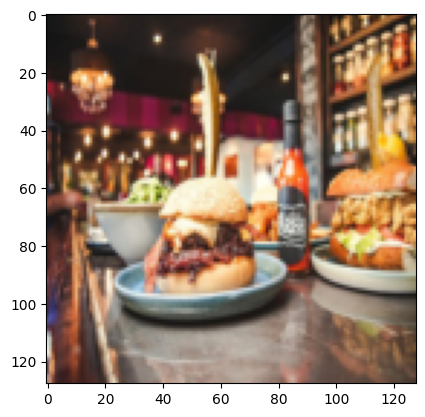

0


'meat'

In [132]:
# image_model = Classifier().to(device)
image_model.load_state_dict(torch.load(root +"/../image/model.ckpt", map_location=lambda storage, loc: storage))
image_model.device = device
image_model.eval()

predictions = []

try:
    for batch in test_loader:
        imgs, labels = batch
        # show image
        plt.imshow(transforms.ToPILImage()(imgs[0]))
        plt.show()
        
        with torch.no_grad():
            logits = image_model(imgs.to(device))
            
        predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
        
#         predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
except:
    pass

# calculate the 
tmp = {}
for i in predictions:
    if i not in tmp:
        tmp[i] = 1
    else:
        tmp[i] += 1
predictions = max(tmp, key=tmp.get)

print(predictions)
if predictions == 0:
    predictions = 'meat'
elif predictions == 1:
    predictions = 'vegetables'
elif predictions == 2:
    predictions = 'pizza'
elif predictions == 3:
    predictions = 'burger'
predictions

In [133]:
if predictions == 'meat':
    recommend = pd.concat([yelp[yelp.categories.str.contains('meat', case=False)], yelp[yelp.categories.str.contains('steak', case=False)]], axis = 0)
    recommend = pd.concat([recommend, yelp[yelp.categories.str.contains('chicken', case=False)]], axis = 0)
else:
    recommend = yelp[yelp.categories.str.contains('veg', case=False)]
recommend['predicted_img_class'] = predictions

In [134]:
recommend['user_id_map'] = recommend['user_id'].apply(lambda x: userid[x])
#recommend = recommend.drop_duplicates(subset=['user_id'])
recommend['business_id_map'] = recommend['business_id'].apply(lambda x: restid[x])
recommend = recommend.drop_duplicates(subset=['business_id'])

In [135]:
recommend = recommend[['user_id', 'user_id_map', 'business_id', 'business_id_map', 'latitude', 'longitude','predicted_img_class', 'text', 'attributes.GoodForKids', 'attributes.BikeParking',
       'attributes.RestaurantsTableService', 'attributes.HasTV',
       'attributes.BusinessAcceptsCreditCards',
       'attributes.RestaurantsTakeOut', 'attributes.RestaurantsGoodForGroups',
       'attributes.BusinessParking.street']]

In [136]:
recommend

,user_id,user_id_map,business_id,business_id_map,latitude,longitude,predicted_img_class,text,attributes.GoodForKids,attributes.BikeParking,attributes.RestaurantsTableService,attributes.HasTV,attributes.BusinessAcceptsCreditCards,attributes.RestaurantsTakeOut,attributes.RestaurantsGoodForGroups,attributes.BusinessParking.street
330,pgtmWFEicHOl07aTjMnQTA,9251,U2fN80Q-QOudDt5V-qjIlw,891,29.971260,-90.091354,meat,Two words: Boudin Eggrolls. I am a bit of a bo...,0,1,0,0,1,1,1,1
621,hQnjE5ACXjrquVkI_XVe4A,7819,mzZ_WTb2zvyJMBkm84B-WA,1473,30.000541,-90.130043,meat,Great local grocery store in Metairie. \n\nGet...,1,1,0,0,1,1,1,0
836,0Igx-a1wAstiBDerGxXk2A,237,QNB4Um92QR49c1w5cKDbIQ,786,29.924390,-90.107385,meat,The little grocery that could... \nI've been s...,1,1,0,0,1,1,0,1
894,hCAGDMzk04uJfq6yBXgRlg,7787,gTC8IQ_i8zXytWSly3Ttvg,1284,29.942236,-90.067098,meat,I was in the neighborhood for a haircut and ne...,1,1,1,1,1,1,1,1
1008,CfX4sTIFFNaRchNswqhVfg,2309,i9ahyW_GpP1nrMomY5BoFQ,1345,30.051575,-89.978903,meat,Tried something new at Walkers and once again ...,1,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26980,OyyPbxMDNiJR2naNyVhX0g,4495,W3iq8S2Yu3bzahLHIhDIKA,946,29.963540,-90.164514,meat,Worst domino's ever!! Ordered pizza at 11:30....,1,0,0,1,1,1,0,0
28114,Qhw72W-6XJnvuUtmS7Rdfw,4813,PEdBeArjVvl2qBM9TvmXPw,752,29.931748,-90.003541,meat,This is the worst Domino's ever. Waited for ov...,0,0,0,0,1,1,0,0
31022,CEsxuhCm8IalcXUhlZpZEw,2224,w3clyF4T0UAYGjTXFtbyLQ,1711,30.009515,-90.265920,meat,The level of rudeness and disrespect from the ...,1,0,0,1,1,1,1,0
31083,ulAbDRjhxJSq2mkhI0KRZw,10120,lND9NcgON8zI1TyTY0fQKg,1428,29.964458,-90.031238,meat,This corner shop is awesome - the banh mi's ar...,0,0,0,0,1,1,0,0


# Rating Model

In [137]:
class ratingModel(nn.Module):
    def __init__(self, n_users, n_restaurants, n_attributes, embedding_dim=30, embedding_dropout=0.3):
        super(ratingModel, self).__init__()

        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.restaurant_embedding = nn.Embedding(n_restaurants, embedding_dim)
        self.attributes_embedding = nn.Embedding(n_attributes, embedding_dim)
        
        self.fc = nn.Sequential(
          nn.Linear(300, 600),
          nn.BatchNorm1d(600),
          nn.LeakyReLU(),
          nn.Dropout(0.5),
          nn.Linear(600, 300),
          nn.BatchNorm1d(300),
          nn.LeakyReLU(),
          nn.Dropout(0.5),
          nn.Linear(300,1)
        )
        
        self.drop = nn.Dropout(embedding_dropout)

    def forward(self, user, restaurant, attributes, minmax=None):
        user_embed = self.user_embedding(user)
        restaurant_embed = self.restaurant_embedding(restaurant)
        attributes_embed = self.attributes_embedding(attributes)
        #print(restaurant_embed.shape, len(restaurant))
        expected_size = user_embed.shape[0]  # Compute expected size of concatenation dimension
        attributes_embed = attributes_embed.reshape(expected_size, -1)  # Adjust size of x3 to match expected size
        x = torch.cat([user_embed, restaurant_embed, attributes_embed], dim=-1)
        x = self.drop(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out

In [138]:
def predict_rating(user, restaurant, attributes):
    rating_predictor = torch.load(root + '/../rating/class_rating_improve.pth')
    rating_predictor.eval()

    # Make a prediction using the model
    rating = rating_predictor(user, restaurant, attributes, minmax=(0, 5))

    # Print the predicted rating
    #print(f"Predicted rating: {rating.item()}")
    return rating.item()

predicted_rating = []

for i in range(len(recommend)):
    user = recommend.iloc[i]['user_id_map']
    restaurant = recommend.iloc[i]['business_id_map']
    attributes = recommend.iloc[i,-8:].tolist()
    user = torch.tensor([user])
    restaurant = torch.tensor([restaurant])
    attributes = torch.tensor(attributes)
    
    predicted_rating.append(predict_rating(user, restaurant, attributes))
recommend['predicted_rating'] = predicted_rating

In [139]:
recommend = recommend[recommend['predicted_rating'] > 4]

In [140]:
recommend[['user_id', 'user_id_map', 'business_id', 'business_id_map', 'latitude', 'longitude', 'predicted_img_class',
       'predicted_rating', 'text']]

,user_id,user_id_map,business_id,business_id_map,latitude,longitude,predicted_img_class,predicted_rating,text
330,pgtmWFEicHOl07aTjMnQTA,9251,U2fN80Q-QOudDt5V-qjIlw,891,29.971260,-90.091354,meat,4.453403,Two words: Boudin Eggrolls. I am a bit of a bo...
621,hQnjE5ACXjrquVkI_XVe4A,7819,mzZ_WTb2zvyJMBkm84B-WA,1473,30.000541,-90.130043,meat,4.131162,Great local grocery store in Metairie. \n\nGet...
836,0Igx-a1wAstiBDerGxXk2A,237,QNB4Um92QR49c1w5cKDbIQ,786,29.924390,-90.107385,meat,4.551034,The little grocery that could... \nI've been s...
894,hCAGDMzk04uJfq6yBXgRlg,7787,gTC8IQ_i8zXytWSly3Ttvg,1284,29.942236,-90.067098,meat,4.079160,I was in the neighborhood for a haircut and ne...
1939,JyohFJOhlMOIvBOS1_TWFA,3650,qFfxWon_Rx99KF4rHViMkQ,1549,30.051127,-89.967019,meat,4.107970,They don't honor their 10% off with a first ti...
...,...,...,...,...,...,...,...,...,...
23914,OJqCJUdWryvAy6BMuGkv4w,4372,P5oa6LgqC6pVca2nbRiiLg,747,29.892827,-90.099476,meat,4.228555,I had gone here and waited over an hour just t...
25533,yeK0QXl5dGAPPKdzzasCPw,10804,TUi-pBF220RnOdb4B4JU0Q,872,29.870935,-90.047458,meat,4.241449,I'm not normally a big fan of wings until I tr...
26610,0ISHpQ-rNVzn2g2ubk8g6Q,234,10hPLwziCqeDbL5sjWtbFQ,65,30.040921,-89.955131,meat,4.049614,"For a small place, the ambience and food, GREA..."
28114,Qhw72W-6XJnvuUtmS7Rdfw,4813,PEdBeArjVvl2qBM9TvmXPw,752,29.931748,-90.003541,meat,4.157771,This is the worst Domino's ever. Waited for ov...


In [141]:
with open('Test1.txt', 'w') as f:
    f.write('id,text'+'\n')
    for i in range(recommend.shape[0]):
        f.write(str(0) + ',' + ' '.join(recommend.text.iloc[i].split()) + '\n')
f.close()

# Text Model

In [142]:
import warnings
warnings.filterwarnings('ignore')
path_prefix = './'

In [143]:
testing_data = 'Test1.txt'
w2v_path = os.path.join(path_prefix, 'w2v_all.model')
sen_len = 29
batch_size = 128
model_dir = root + '/../text/'

In [144]:
import torch
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.nn.functional as F

def load_training_data(path='Train_label.txt'):
    # Read training data
    if 'Train_label' in path:
        with open(path, 'r') as f:
            lines = f.readlines()
            lines = [line.strip('\n').split(' ') for line in lines]
        x = [line[2:] for line in lines]
        y = [line[0] for line in lines]
        return x, y
    else:
        with open(path, 'r') as f:
            lines = f.readlines()
            x = [line.strip('\n').split(' ') for line in lines]
        return x

def load_testing_data(path='Test.txt'):
    # Read testing data
    with open(path, 'r') as f:
        lines = f.readlines()
        X = ["".join(line.strip('\n').split(",")[1:]).strip() for line in lines[1:]]
        X = [sen.split(' ') for sen in X]
    return X

def evaluation(outputs, labels):
    #outputs => probability (float)
    #labels => labels
    outputs[outputs>=0.6] = 1 # Positive Sentiment
    outputs[outputs<0.6] = 0 # Negative Sentiment
    correct = torch.sum(torch.eq(outputs, labels)).item()
    return correct

In [145]:
import os
import numpy as np
import pandas as pd
import argparse
from gensim.models import word2vec

def train_word2vec(x):
    model = word2vec.Word2Vec(x, vector_size=250, window=5, min_count=5, workers=12)
    return model

if __name__ == "__main__":
    print("loading training data ...")
    train_x, y = load_training_data(root + '/../text/Train_label.txt')
    train_x_no_label = load_training_data(root + '/../text/Train_nolabel.txt')

    print("loading testing data ...")
    test_x = load_testing_data(testing_data)

    model = train_word2vec(train_x + train_x_no_label + test_x)
    
    print("saving model ...")
    model.save(os.path.join(path_prefix, 'w2v_all.model'))

loading training data ...
loading testing data ...
saving model ...


In [146]:
from torch import nn
from gensim.models import Word2Vec

class Preprocess():
    def __init__(self, sentences, sen_len, w2v_path="./w2v.model"):
        self.w2v_path = w2v_path
        self.sentences = sentences
        self.sen_len = sen_len
        self.idx2word = []
        self.word2idx = {}
        self.embedding_matrix = []
    def get_w2v_model(self):
        # load word to vector model
        self.embedding = Word2Vec.load(self.w2v_path)
        self.embedding_dim = self.embedding.vector_size
    def add_embedding(self, word):
        # add word into embedding
        vector = torch.empty(1, self.embedding_dim)
        torch.nn.init.uniform_(vector)
        self.word2idx[word] = len(self.word2idx)
        self.idx2word.append(word)
        self.embedding_matrix = torch.cat([self.embedding_matrix, vector], 0)
    def make_embedding(self, load=True):
        print("Get embedding ...")
        if load:
            print("loading word to vec model ...")
            self.get_w2v_model()
        else:
            raise NotImplementedError

        for i, word in enumerate(self.embedding.wv.key_to_index):
            print('get words #{}'.format(i+1), end='\r')
            self.word2idx[word] = len(self.word2idx)
            self.idx2word.append(word)
            self.embedding_matrix.append(self.embedding.wv[word])
        print('')
        self.embedding_matrix = torch.tensor(self.embedding_matrix)
        self.add_embedding("<PAD>")
        self.add_embedding("<UNK>")
        print("total words: {}".format(len(self.embedding_matrix)))
        return self.embedding_matrix
    def pad_sequence(self, sentence):
        if len(sentence) > self.sen_len:
            sentence = sentence[:self.sen_len]
        else:
            pad_len = self.sen_len - len(sentence)
            for _ in range(pad_len):
                sentence.append(self.word2idx["<PAD>"])
        assert len(sentence) == self.sen_len
        return sentence
    def sentence_word2idx(self):
        sentence_list = []
        for i, sen in enumerate(self.sentences):
            print('sentence count #{}'.format(i+1), end='\r')
            sentence_idx = []
            for word in sen:
                if (word in self.word2idx.keys()):
                    sentence_idx.append(self.word2idx[word])
                else:
                    sentence_idx.append(self.word2idx["<UNK>"])
            sentence_idx = self.pad_sequence(sentence_idx)
            sentence_list.append(sentence_idx)
        return torch.LongTensor(sentence_list)
    def labels_to_tensor(self, y):
        # turn labels into tensors
        y = [int(label) for label in y]
        return torch.LongTensor(y)

In [147]:
import torch
from torch.utils import data

class TwitterDataset(data.Dataset):
    """
    Expected data shape like:(data_num, data_len)
    Data can be a list of numpy array or a list of lists
    input data shape : (data_num, seq_len, feature_dim)
    
    __len__ will return the number of data
    """
    def __init__(self, X, y):
        self.data = X
        self.label = y
    def __getitem__(self, idx):
        if self.label is None: return self.data[idx]
        return self.data[idx], self.label[idx]
    def __len__(self):
        return len(self.data)

In [148]:
import torch
from torch import nn
class LSTM_Net(nn.Module):
    def __init__(self, embedding, embedding_dim, hidden_dim, num_layers, dropout=0.5, fix_embedding=True):
        super(LSTM_Net, self).__init__()
        # embedding layer
        self.embedding = torch.nn.Embedding(embedding.size(0),embedding.size(1))
        self.embedding.weight = torch.nn.Parameter(embedding)
        # Whether fix embedding
        self.embedding.weight.requires_grad = False if fix_embedding else True
        self.embedding_dim = embedding.size(1)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.classifier = nn.Sequential( nn.Dropout(dropout),
                                         nn.Linear(hidden_dim, 256),
                                        nn.Dropout(0.2),
                                         nn.Sigmoid(),
                                         nn.Linear(256,1),
                                        nn.Dropout(0.1),
                                         nn.Sigmoid())
    def forward(self, inputs):
        inputs = self.embedding(inputs)
        x, _ = self.lstm(inputs, None)
        # dimension of x (batch, seq_len, hidden_size)
        x = x[:, -1, :] 
        x = self.classifier(x)
        return x

In [149]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

def testing(batch_size, test_loader, model, device):
    model.eval()
    ret_output = []
    with torch.no_grad():
        for i, inputs in enumerate(test_loader):
            inputs = inputs.to(device, dtype=torch.long)
            outputs = model(inputs)
            outputs = outputs.squeeze()
            outputs[outputs>=0.6] = 1
            outputs[outputs<0.6] = 0
            ret_output += outputs.int().tolist()
    
    return ret_output

In [150]:
print("loading testing data ...")
test_x = load_testing_data(testing_data)
preprocess = Preprocess(test_x, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding(load=True)
test_x = preprocess.sentence_word2idx()
test_dataset = TwitterDataset(X=test_x, y=None)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 0)
print('\nload model ...')
device = "cuda" if torch.cuda.is_available() else "cpu"
text_model = torch.load(os.path.join(model_dir, 'ckpt.model'),map_location=torch.device(device))
outputs = testing(batch_size, test_loader, text_model, device)

loading testing data ...
Get embedding ...
loading word to vec model ...
get words #24033
total words: 24035
sentence count #78
load model ...


In [151]:
recommend['predicted_sentiment'] = outputs

In [152]:
recommend

,user_id,user_id_map,business_id,business_id_map,latitude,longitude,predicted_img_class,text,attributes.GoodForKids,attributes.BikeParking,attributes.RestaurantsTableService,attributes.HasTV,attributes.BusinessAcceptsCreditCards,attributes.RestaurantsTakeOut,attributes.RestaurantsGoodForGroups,attributes.BusinessParking.street,predicted_rating,predicted_sentiment
330,pgtmWFEicHOl07aTjMnQTA,9251,U2fN80Q-QOudDt5V-qjIlw,891,29.971260,-90.091354,meat,Two words: Boudin Eggrolls. I am a bit of a bo...,0,1,0,0,1,1,1,1,4.453403,0
621,hQnjE5ACXjrquVkI_XVe4A,7819,mzZ_WTb2zvyJMBkm84B-WA,1473,30.000541,-90.130043,meat,Great local grocery store in Metairie. \n\nGet...,1,1,0,0,1,1,1,0,4.131162,1
836,0Igx-a1wAstiBDerGxXk2A,237,QNB4Um92QR49c1w5cKDbIQ,786,29.924390,-90.107385,meat,The little grocery that could... \nI've been s...,1,1,0,0,1,1,0,1,4.551034,0
894,hCAGDMzk04uJfq6yBXgRlg,7787,gTC8IQ_i8zXytWSly3Ttvg,1284,29.942236,-90.067098,meat,I was in the neighborhood for a haircut and ne...,1,1,1,1,1,1,1,1,4.079160,0
1939,JyohFJOhlMOIvBOS1_TWFA,3650,qFfxWon_Rx99KF4rHViMkQ,1549,30.051127,-89.967019,meat,They don't honor their 10% off with a first ti...,1,1,1,1,1,1,1,1,4.107970,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23914,OJqCJUdWryvAy6BMuGkv4w,4372,P5oa6LgqC6pVca2nbRiiLg,747,29.892827,-90.099476,meat,I had gone here and waited over an hour just t...,0,0,0,0,1,0,1,0,4.228555,0
25533,yeK0QXl5dGAPPKdzzasCPw,10804,TUi-pBF220RnOdb4B4JU0Q,872,29.870935,-90.047458,meat,I'm not normally a big fan of wings until I tr...,0,0,0,0,0,0,0,0,4.241449,0
26610,0ISHpQ-rNVzn2g2ubk8g6Q,234,10hPLwziCqeDbL5sjWtbFQ,65,30.040921,-89.955131,meat,"For a small place, the ambience and food, GREA...",0,0,0,1,0,0,0,0,4.049614,0
28114,Qhw72W-6XJnvuUtmS7Rdfw,4813,PEdBeArjVvl2qBM9TvmXPw,752,29.931748,-90.003541,meat,This is the worst Domino's ever. Waited for ov...,0,0,0,0,1,1,0,0,4.157771,0


In [153]:
recommend.groupby('business_id').count()

,user_id,user_id_map,business_id_map,latitude,longitude,predicted_img_class,text,attributes.GoodForKids,attributes.BikeParking,attributes.RestaurantsTableService,attributes.HasTV,attributes.BusinessAcceptsCreditCards,attributes.RestaurantsTakeOut,attributes.RestaurantsGoodForGroups,attributes.BusinessParking.street,predicted_rating,predicted_sentiment
business_id,,,,,,,,,,,,,,,,,
-1XSzguS6XLN-V6MVZMg2A,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
-YxrHNjPHfha1h2Kvm_G0w,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
10hPLwziCqeDbL5sjWtbFQ,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2GoW5x7cNCdbdUnk54Uuug,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2QGyW4T6E_4iSltdx9i2RQ,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
umq4JEgX4U6TIdMv-odD0Q,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
vfmHUg7jWnfzLb90vcuLSg,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
y-g8sgT7WkN16BBe9Vj41g,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [154]:
rec = recommend[recommend.predicted_sentiment == 1][['user_id', 'business_id', 'latitude', 'longitude', 'predicted_img_class', 'predicted_rating', 'predicted_sentiment']].reset_index(drop=True)

In [155]:
rec

,user_id,business_id,latitude,longitude,predicted_img_class,predicted_rating,predicted_sentiment
0,hQnjE5ACXjrquVkI_XVe4A,mzZ_WTb2zvyJMBkm84B-WA,30.000541,-90.130043,meat,4.131162,1
1,zxyKewY6p0CjnFprEutaog,FQJ4ph8e1SMz5YWsdH2m8Q,29.940153,-90.075188,meat,4.116067,1
2,zxyKewY6p0CjnFprEutaog,-1XSzguS6XLN-V6MVZMg2A,29.943537,-90.065372,meat,4.324313,1
3,4YyJpeAr6jsY0FaIbLiTSQ,Da7VCyHFQNTNHaB7eJYrwA,30.003808,-90.103658,meat,4.325589,1
4,0Igx-a1wAstiBDerGxXk2A,4rvAW2dFV24sdGcOLWcU5w,29.937765,-90.071258,meat,4.056920,1
5,CfX4sTIFFNaRchNswqhVfg,R6P3KSFafpKz6bEtHsWz1A,29.967377,-90.102028,meat,4.204603,1
6,FxsM4PP3EHty06aS4GK5hg,C26xmwM2_OgJJi2BbL3KkQ,29.954392,-90.068741,meat,4.175303,1
7,li7KSgwtFCgdaD3XYaPrAw,MDtu8_LFbbkCgzCzIoEWng,29.959033,-90.064036,meat,4.353622,1
8,rdQo1I6tjjR2Wg6UUu5ZnQ,guwb1zuNEMtJVproo0ntFw,29.943455,-90.067341,meat,4.321863,1
9,p951o8o4e3cHC1DSyiKP7Q,32exKYuOUcXARWrhvAYzVQ,30.017931,-90.200290,meat,4.281239,1


In [156]:
mapp = yelp.set_index('business_id')['review_count'].to_dict()
rec['review_count'] = rec.business_id.map(mapp)

In [157]:
rec.sort_values(by=['review_count', 'predicted_rating'], ascending=False).to_csv('final.csv', index=False)

recommend[recommend.predicted_sentiment == 1][['user_id', 'business_id', 'latitude', 'longitude', 'predicted_img_class', 'predicted_rating', 'predicted_sentiment']].head(10).reset_index(drop=True).to_csv('final.csv', index = False)